<a href="https://colab.research.google.com/github/FlowSight/MlAlgoFromScratch/blob/master/utils.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [ ]:
import traceback
import warnings
import sys
def warn_with_traceback(message, category, filename, lineno, file=None, line=None):

    log = file if hasattr(file,'write') else sys.stderr
    traceback.print_stack(file=log)
    log.write(warnings.formatwarning(message, category, filename, lineno, line))

warnings.showwarning = warn_with_traceback

In [ ]:
class Sigmoid():
    def __call__(self, x):
        return 1 / (1 + np.exp(-x))

    def gradient(self, x):
        return self.__call__(x) * (1 - self.__call__(x))

class Softmax():
    def __call__(self, x):
        e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return e_x / np.sum(e_x, axis=-1, keepdims=True)

    def gradient(self, x):
        p = self.__call__(x)
        return p * (1 - p)

class Loss(object):
    def loss(self, y_true, y_pred):
        return NotImplementedError()

    def gradient(self, y, y_pred):
        raise NotImplementedError()

    def acc(self, y, y_pred):
        return 0

class SquareLoss(Loss):
    def __init__(self): pass

    def loss(self, y, y_pred):
        return 0.5 * np.power((y - y_pred), 2)

    def gradient(self, y, y_pred):
        return -(y - y_pred)

    def hessian(self, y, y_pred):
        return 1


class CrossEntropy(Loss):
    def __init__(self): pass

    def loss(self, y, p):
        # Avoid division by zero
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return - y * np.log(p) - (1 - y) * np.log(1 - p)

    def acc(self, y, p):
        return accuracy_score(np.argmax(y, axis=1), np.argmax(p, axis=1))

    def gradient(self, y, p):
        # Avoid division by zero
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return - (y / p) + (1 - y) / (1 - p)

    def hessian(self,y,p):
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return y/(p**2) + (1-y)/(1-p)**2

class LogisticLoss():
    def __init__(self):
        sigmoid = Sigmoid()
        self.log_func = sigmoid
        self.log_grad = sigmoid.gradient

    def loss(self, y, y_pred):
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        p = self.log_func(y_pred)
        return y * np.log(p) + (1 - y) * np.log(1 - p)
  
    def gradient(self, y, y_pred):
        p = self.log_func(y_pred)
        return -(y - p)

    def hessian(self, y, y_pred):
        p = self.log_func(y_pred)
        return p * (1 - p)

def to_categorical(x, n_col=None):
    if not n_col:
        n_col = np.amax(x) + 1
    one_hot = np.zeros((x.shape[0], n_col))
    one_hot[np.arange(x.shape[0]), x] = 1
    return one_hot

def normalize(X, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)


def standardize(X):
    X_std = X
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    for col in range(np.shape(X)[1]):
        if std[col]:
            X_std[:, col] = (X_std[:, col] - mean[col]) / std[col]
    return X_std

class TanH():
    def __call__(self, x):
        return 2 / (1 + np.exp(-2*x)) - 1

    def gradient(self, x):
        return 1 - np.power(self.__call__(x), 2)

class ReLU():
    def __call__(self, x):
        return np.where(x >= 0, x, 0)

    def gradient(self, x):
        return np.where(x >= 0, 1, 0)

class LeakyReLU():
    def __init__(self, alpha=0.2):
        self.alpha = alpha

    def __call__(self, x):
        return np.where(x >= 0, x, self.alpha * x)

    def gradient(self, x):
        return np.where(x >= 0, 1, self.alpha)

class ELU():
    def __init__(self, alpha=0.1):
        self.alpha = alpha 

    def __call__(self, x):
        return np.where(x >= 0.0, x, self.alpha * (np.exp(x) - 1))

    def gradient(self, x):
        return np.where(x >= 0.0, 1, self.__call__(x) + self.alpha)

class SELU():
    # Reference : https://arxiv.org/abs/1706.02515,
    # https://github.com/bioinf-jku/SNNs/blob/master/SelfNormalizingNetworks_MLP_MNIST.ipynb
    def __init__(self):
        self.alpha = 1.6732632423543772848170429916717
        self.scale = 1.0507009873554804934193349852946 

    def __call__(self, x):
        return self.scale * np.where(x >= 0.0, x, self.alpha*(np.exp(x)-1))

    def gradient(self, x):
        return self.scale * np.where(x >= 0.0, 1, self.alpha * np.exp(x))

class SoftPlus():
    def __call__(self, x):
        return np.log(1 + np.exp(x))

    def gradient(self, x):
        return 1 / (1 + np.exp(-x))


class StochasticGradientDescent():
    def __init__(self, learning_rate=0.01, momentum=0):
        self.learning_rate = learning_rate 
        self.momentum = momentum
        self.w_updt = None

    def update(self, w, grad_wrt_w):
        # If not initialized
        if self.w_updt is None:
            self.w_updt = np.zeros(np.shape(w))
        # Use momentum if set
        self.w_updt = self.momentum * self.w_updt + (1 - self.momentum) * grad_wrt_w
        # Move against the gradient to minimize loss
        return w - self.learning_rate * self.w_updt

class NesterovAcceleratedGradient():
    def __init__(self, learning_rate=0.001, momentum=0.4):
        self.learning_rate = learning_rate 
        self.momentum = momentum
        self.w_updt = np.array([])

    def update(self, w, grad_func):
        # Calculate the gradient of the loss a bit further down the slope from w
        approx_future_grad = np.clip(grad_func(w - self.momentum * self.w_updt), -1, 1)
        # Initialize on first update
        if not self.w_updt.any():
            self.w_updt = np.zeros(np.shape(w))

        self.w_updt = self.momentum * self.w_updt + self.learning_rate * approx_future_grad
        # Move against the gradient to minimize loss
        return w - self.w_updt

class Adagrad(): # helps in sparse gradient
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate
        self.G = None # Sum of squares of the gradients
        self.eps = 1e-8

    def update(self, w, grad_wrt_w):
        # If not initialized
        if self.G is None:
            self.G = np.zeros(np.shape(w))
        # Add the square of the gradient of the loss function at w
        self.G += np.power(grad_wrt_w, 2)
        # Adaptive gradient with higher learning rate for sparse data
        return w - self.learning_rate * grad_wrt_w / np.sqrt(self.G + self.eps)

class Adadelta(): # speciality: no learning rate needed
    def __init__(self, rho=0.95, eps=1e-6):
        self.E_w_updt = None # Running average of squared parameter updates
        self.E_grad = None   # Running average of the squared gradient of w
        self.w_updt = None   # Parameter update
        self.eps = eps
        self.rho = rho

    def update(self, w, grad_wrt_w):
        # If not initialized
        if self.w_updt is None:
            self.w_updt = np.zeros(np.shape(w))
            self.E_w_updt = np.zeros(np.shape(w))
            self.E_grad = np.zeros(np.shape(grad_wrt_w))

        # Update average of gradients at w
        self.E_grad = self.rho * self.E_grad + (1 - self.rho) * np.power(grad_wrt_w, 2)  # this term is moving avg of derivative of ws
        RMS_delta_w = np.sqrt(self.E_w_updt + self.eps)
        RMS_grad = np.sqrt(self.E_grad + self.eps)
        # Adaptive learning rate
        adaptive_lr = RMS_delta_w / RMS_grad
        # Calculate the update
        self.w_updt = adaptive_lr * grad_wrt_w
        # Update the running average of w updates
        self.E_w_updt = self.rho * self.E_w_updt + (1 - self.rho) * np.power(self.w_updt, 2) # this term is moving avg of change in w
        return w - self.w_updt

class RMSprop():
    def __init__(self, learning_rate=0.01, rho=0.9):
        self.learning_rate = learning_rate
        self.Eg = None # Running average of the square gradients at w
        self.eps = 1e-8
        self.rho = rho

    def update(self, w, grad_wrt_w):
        if self.Eg is None:
            self.Eg = np.zeros(np.shape(grad_wrt_w))

        self.Eg = self.rho * self.Eg + (1 - self.rho) * np.power(grad_wrt_w, 2)
        # Divide the learning rate for a weight by a running average of the magnitudes of recent
        # gradients for that weight
        return w - self.learning_rate *  grad_wrt_w / np.sqrt(self.Eg + self.eps)

class Adam():
    def __init__(self, learning_rate=0.001, b1=0.9, b2=0.999):
        self.learning_rate = learning_rate
        self.eps = 1e-8
        self.m = None
        self.v = None
        # Decay rates
        self.b1 = b1
        self.b2 = b2

    def update(self, w, grad_wrt_w):
        # If not initialized
        if self.m is None:
            self.m = np.zeros(np.shape(grad_wrt_w))
            self.v = np.zeros(np.shape(grad_wrt_w))
        
        self.m = self.b1 * self.m + (1 - self.b1) * grad_wrt_w
        self.v = self.b2 * self.v + (1 - self.b2) * np.power(grad_wrt_w, 2)

        m_hat = self.m / (1 - self.b1)
        v_hat = self.v / (1 - self.b2)

        self.w_updt = self.learning_rate * m_hat / (np.sqrt(v_hat) + self.eps)

        return w - self.w_updt



In [ ]:
x=np.array([1,2,3,4,5])
np.sqrt(x)/np.sqrt(x)

array([1., 1., 1., 1., 1.])

In [ ]:
class MultiClassLDA():
    def __init__(self, solver="svd"):
        self.solver = solver

    def _calculate_scatter_matrices(self, X, y):
        n_features = np.shape(X)[1]
        labels = np.unique(y)

        # Within class scatter matrix:
        # SW = sum{ (X_for_class - mean_of_X_for_class)^2 }
        #   <=> (n_samples_X_for_class - 1) * covar(X_for_class)
        SW = np.empty((n_features, n_features))
        for label in labels:
            _X = X[y == label]
            SW +=  (len(_X) - 1)*np.cov(_X.T)

        # Between class scatter:
        # SB = sum{ n_samples_for_class * (mean_for_class - total_mean)^2 }
        total_mean = np.mean(X, axis=0)
        SB = np.empty((n_features, n_features))
        for label in labels:
            _X = X[y == label]
            _mean = np.mean(_X, axis=0)
            SB += len(_X) * (_mean - total_mean).dot((_mean - total_mean).T)

        return SW, SB

    def transform(self, X, y, n_components):
        SW, SB = self._calculate_scatter_matrices(X, y)

        # Determine SW^-1 * SB by calculating inverse of SW
        A = np.linalg.inv(SW).dot(SB)

        # Get eigenvalues and eigenvectors of (SW^-1 * SB) ( inverse of SW as within class variance is to be minimized)
        eigenvalues, eigenvectors = np.linalg.eigh(A)
        print(eigenvectors.shape)

        # Sort the eigenvalues and corresponding eigenvectors from largest
        # to smallest eigenvalue and select the first n_components
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx][:n_components]
        eigenvectors = eigenvectors[:, idx][:, :n_components]

        # Project the data onto eigenvectors
        X_transformed = X.dot(eigenvectors)

        return X_transformed


    def plot_in_2d(self, X, y, title=None):
        """ Plot the dataset X and the corresponding labels y in 2D using the LDA
        transformation."""
        X_transformed = self.transform(X, y, n_components=2)
        x1 = X_transformed[:, 0]
        x2 = X_transformed[:, 1]
        plt.scatter(x1, x2, c=y)
        if title: plt.title(title)
        plt.show()


(4, 4)


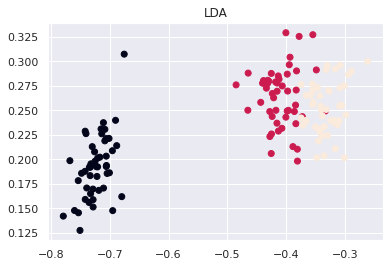

In [ ]:
data = datasets.load_iris()
X = normalize(data.data)
y = data.target
print()
multi_class_lda = MultiClassLDA()
multi_class_lda.plot_in_2d(X, y, title="LDA")